In [49]:
import pandas as pd
import time 
import json
import urllib.request
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from pandas.io.json import json_normalize
from joblib import Parallel, delayed
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error

## Importing RPi JSON Data to DataFrame

In [50]:
df = pd.read_json("https://alte-rs.ddnss.de/weather/processed/history.json")
df['time'] = pd.to_datetime(df['time'])
df['temp'] = pd.to_numeric(df['temp'])
df['pressure'] = pd.to_numeric(df['pressure'])
df['humidity'] = pd.to_numeric(df['humidity'])
dataframe_rpi = df.set_index('time')
print(dataframe_rpi.shape)
dataframe_rpi.head()

(44377, 3)


,humidity,pressure,temp
time,,,
2018-06-22 16:20:01.656,36.116451,1025.179932,28.907051
2018-06-22 16:20:40.606,35.238693,1025.148682,28.870728
2018-06-22 16:21:19.756,35.684219,1025.106445,28.852566
2018-06-22 16:21:58.636,35.843815,1025.139404,28.907051
2018-06-22 16:22:37.505,36.053280,1025.058105,28.870728


## Smoothing RPi Data

### Resampling

## Time Constants Definitions

In [89]:
# predicting the next 120 minutes
prediction_steps = 72
history_steps = 24
window_length = '5min'

(12672, 3)
humidity    0
pressure    0
temp        0
dtype: int64
                      humidity     pressure       temp
time                                                  
2018-06-22 16:20:00  36.116451  1025.179932  28.907051
2018-06-22 16:25:00  35.584476  1025.077637  28.816238
2018-06-22 16:30:00  36.844593  1025.135742  28.580128
2018-06-22 16:35:00  38.207783  1025.225342  28.235043
2018-06-22 16:40:00  38.450497  1025.273438  28.198719


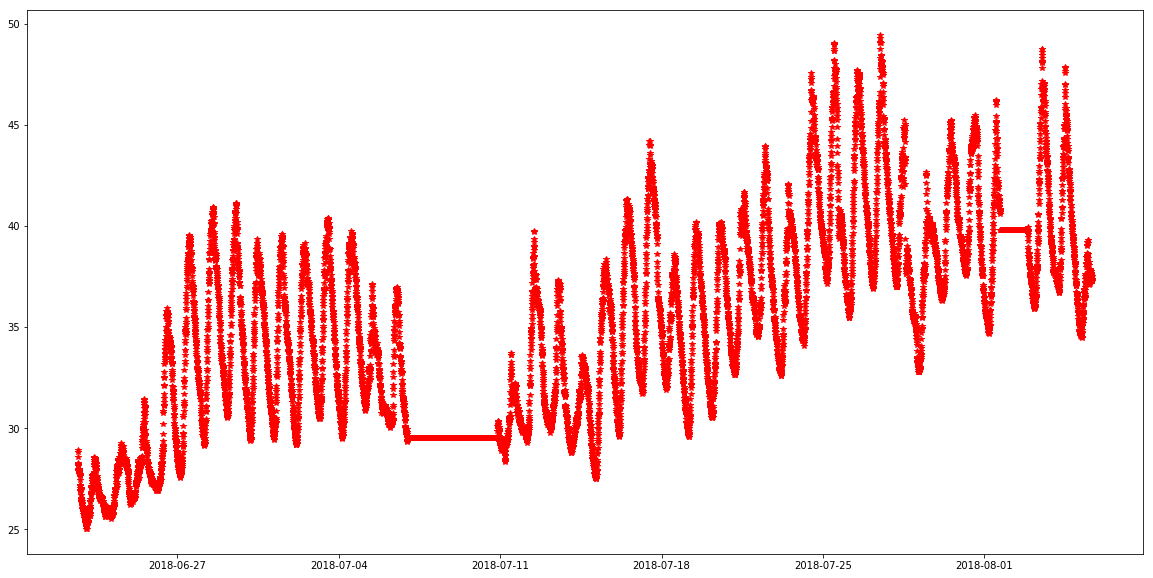

In [90]:
dataframe_rpi_resampled = dataframe_rpi.resample(window_length).bfill()



print(dataframe_rpi_resampled.shape)
print(dataframe_rpi_resampled.isnull().sum())
print(dataframe_rpi_resampled.head())
plt.figure(figsize=(20,10))
plt.plot(dataframe_rpi_resampled['temp'],'r*')

## Creating Feature Matrix and Prediction Vector

### Reducing the input values to a maxmimum of one row every 5min

### Creating prediction matrix y 

In [91]:
dataframe_input=dataframe_rpi_resampled
# dataframe_input = dataframe_rpi_rolling



y = dataframe_input[ prediction_steps + history_steps :]
y_index = dataframe_input[ prediction_steps + history_steps :].index

length = len(y)
print(y.shape)
print(np.isnan(y).sum())

(12576, 3)
humidity    0
pressure    0
temp        0
dtype: int64


### Creating input matrix x, which contains history_steps consequtive historical values (time steps)

In [92]:
x = np.empty((length, 3*history_steps))


def xrow (start):
    return dataframe_input[ start : start + history_steps ].values.flatten();


for n in  range(0,length):
    x[n] =xrow(n)
print(x.shape)
print(np.isnan(x).sum())

(12576, 72)
0


## Scaling the features and splitting up into training and testing

In [93]:
cut = y_index.get_loc('2018-07-11 00:00:00')

In [94]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# x_train_sc = scaler.fit_transform(x_train)
# x_test_sc = scaler.fit_transform(x_test)
x_scaled = scaler.fit_transform(x)


#cut=len(y)*4//5 # First part of data is for training, the other testing

y_train = y[cut:]
x_train = x_scaled[cut:]
y_test = y[0:cut]
x_test = x_scaled[0:cut]

## Learning with linear regression

In [95]:
training_data_input  = x_train
training_data_target = y_train

testing_data_input   = x_test
testing_data_target  = y_test



from sklearn.linear_model import LinearRegression
regressor_temp = LinearRegression(n_jobs=-1)
regressor_temp = regressor_temp.fit(training_data_input, training_data_target['temp'])
sorted_coefs_temp = regressor_temp.coef_.reshape(history_steps,3)
intercept_temp = regressor_temp.intercept_

regressor_hum = LinearRegression(n_jobs=-1)
regressor_hum = regressor_hum.fit(training_data_input, training_data_target['humidity'])
sorted_coefs_hum = regressor_hum.coef_.reshape(history_steps,3)
intercept_hum = regressor_hum.intercept_

regressor_press = LinearRegression(n_jobs=-1)
regressor_press = regressor_press.fit(training_data_input, training_data_target['pressure'])
sorted_coefs_hum = regressor_press.coef_.reshape(history_steps,3)
intercept_hum = regressor_press.intercept_

training_result = pd.DataFrame(data={'temp' : regressor_temp.predict(training_data_input),'pressure' : regressor_press.predict(training_data_input), 'humidity' : regressor_hum.predict(training_data_input)}, index=y_train.index)
testing_result  = pd.DataFrame(data={'temp' : regressor_temp.predict(testing_data_input),'pressure' : regressor_press.predict(testing_data_input), 'humidity' : regressor_hum.predict(testing_data_input)}, index=y_test.index)

## Gathering Statistics

                            OLS Regression Results                            
Dep. Variable:                   temp   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     88.22
Date:                Sun, 05 Aug 2018   Prob (F-statistic):               0.00
Time:                        18:46:42   Log-Likelihood:                -19306.
No. Observations:                7396   AIC:                         3.876e+04
Df Residuals:                    7323   BIC:                         3.926e+04
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.0083      0.046    779.930      0.0

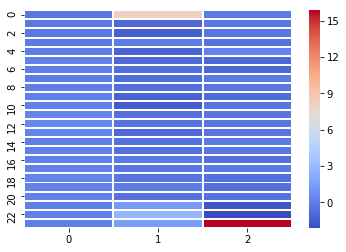

In [96]:
training_data_const = sm.add_constant(training_data_input)
linear_model = sm.OLS(training_data_target['temp'], training_data_const)
insample_stats = linear_model.fit()
testing_data_const = sm.add_constant(testing_data_input)
outsample_stats = insample_stats.predict(testing_data_const)

sn.heatmap(sorted_coefs_temp,cmap='coolwarm',linewidths=1)

print(insample_stats.summary())
#print(outsample_stats.summary())


### Interpreting the statistics

Question - Is there a relationship at all between the response and predictors?
Answer - F statistic
Here : F value is large (Essentially number of standard deviations of an event when there is no relationship and the results seen are just due to chance) 
       Probability of F value is zero -> There is a linear relationship!
       t-statistic of individual variables (probability that a variable is zero and its
       contribution is produced by chance is low for:
       const, x1, x3, x4, x6, x21, x22,x24,x25,x27,x28,x29,x30
       However, number of variables is large, so that some of them are probably due to chance
       R^2 is close to 1 and explains how much of the variablitiy of the response can
       be explained by the model.
       

Root Mean squared errors on train and test


In [97]:
for column in training_data_target.columns:
    err = np.sqrt(mean_squared_error(training_data_target[column],training_result[column]))
    print('Error in ' + column, err)

Error in humidity 5.406942404261843
Error in pressure 1.1527762734020188
Error in temp 3.291652808278856


In [98]:
for column in testing_data_target.columns:
    err = np.sqrt(mean_squared_error(testing_data_target[column],testing_result[column]))
    print('Error in ' + column, err)

Error in humidity 6.281809086199181
Error in pressure 1.0152528407477328
Error in temp 3.8059338856523603




## In-Sample and Out-Of-Sample Plots

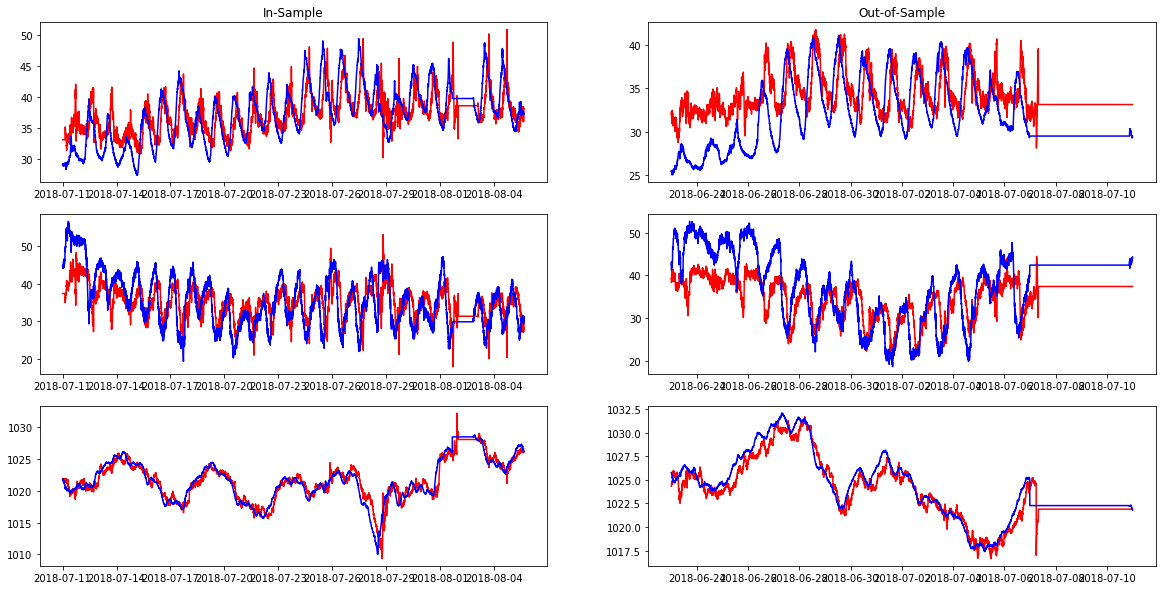

In [99]:
plt.figure(1,figsize=(20,10))
plt.subplot(321)
plt.plot(training_result['temp'],'r-',training_data_target['temp'],'b-')
plt.title('In-Sample')
plt.subplot(323)
plt.plot(training_result['humidity'],'r-',training_data_target['humidity'],'b-')
plt.subplot(325)
plt.plot(training_result['pressure'],'r-',training_data_target['pressure'],'b-')
plt.subplot(322)
plt.plot(testing_result['temp'],'r-',testing_data_target['temp'],'b-')
plt.title('Out-of-Sample')
plt.subplot(324)
plt.plot(testing_result['humidity'],'r-',testing_data_target['humidity'],'b-')
plt.subplot(326)
plt.plot(testing_result['pressure'],'r-',testing_data_target['pressure'],'b-')

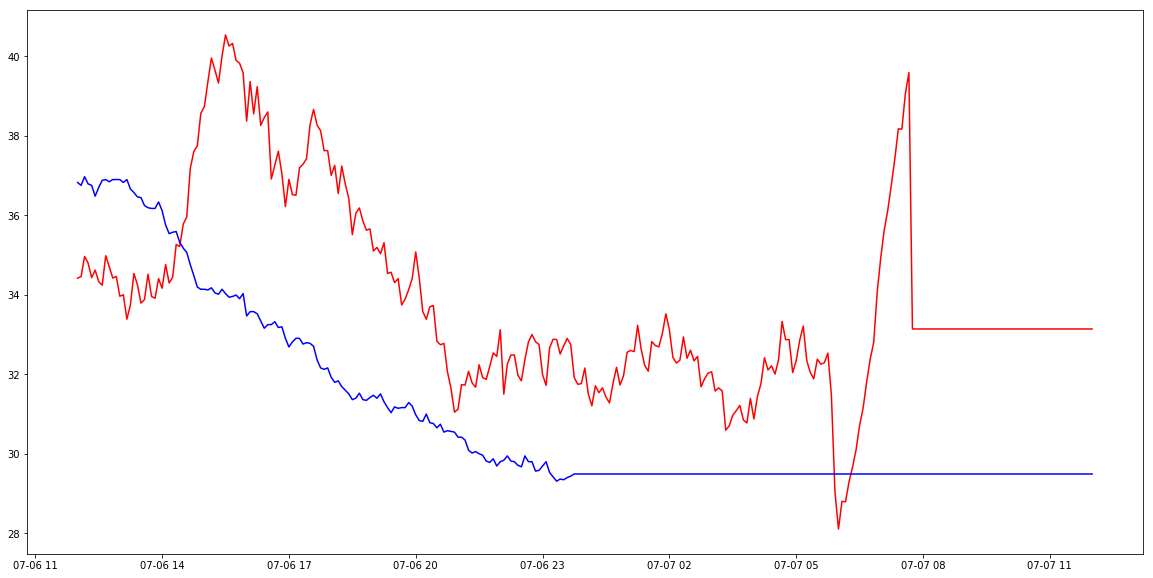

In [100]:
plt.figure(1,figsize=(20,10))

date = y_index[y_index.get_loc('2018-07-06 12:00:00')]

plt.plot(testing_result['temp'][date:date+timedelta(days=1)],'r-',testing_data_target['temp'][date:date+timedelta(days=1)],'b-')

## Diagnostic Plots

https://data.library.virginia.edu/diagnostic-plots/

https://medium.com/@emredjan/emulating-r-regression-plots-in-python-43741952c034

In [101]:
model_fitted_y = insample_stats.fittedvalues

# model residuals
model_residuals = insample_stats.resid

# normalized residuals
model_norm_residuals = insample_stats.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = insample_stats.get_influence().hat_matrix_diag

# cook's distance, from statsmodels internals
model_cooks = insample_stats.get_influence().cooks_distance[0]

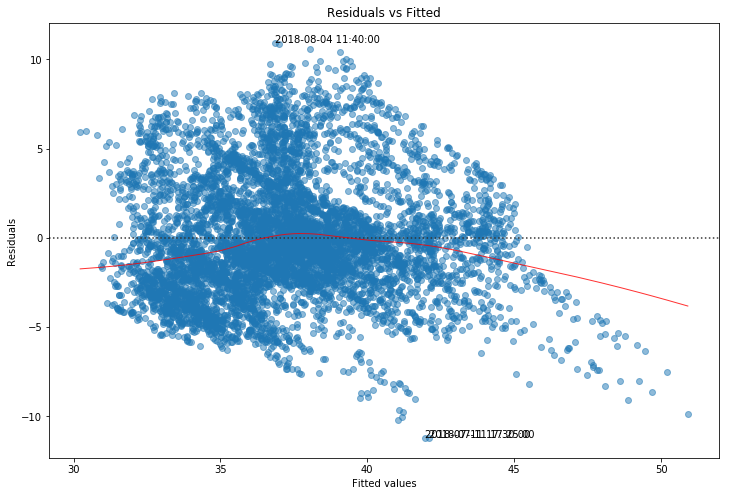

In [102]:
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)

plot_lm_1.axes[0] = sn.residplot(model_fitted_y, training_data_target['temp'],  
                          lowess=True, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

# annotations
abs_resid = model_abs_resid.sort_values(ascending=False)
abs_resid_top_3 = abs_resid[:3]

for i in abs_resid_top_3.index:
    plot_lm_1.axes[0].annotate(i, 
                               xy=(model_fitted_y[i], 
                                   model_residuals[i]));

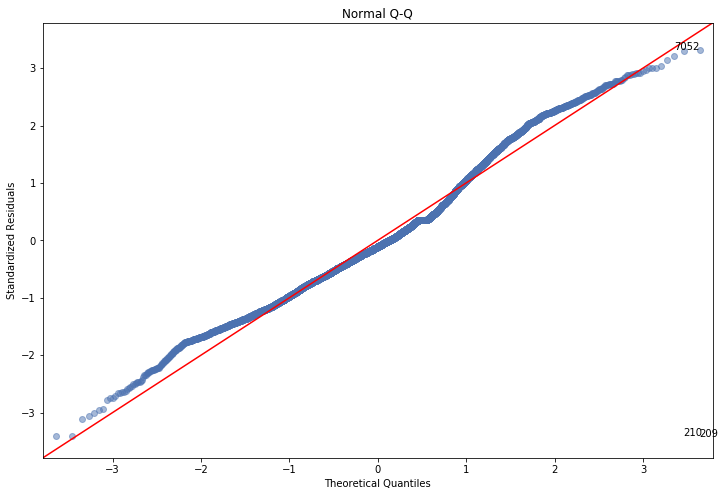

In [103]:
from statsmodels.graphics.gofplots import ProbPlot
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)

plot_lm_2.set_figheight(8)
plot_lm_2.set_figwidth(12)

plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');

# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]

for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i, 
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

In [ ]:
plot_lm_3 = plt.figure(3)
plot_lm_3.set_figheight(8)
plot_lm_3.set_figwidth(12)

plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
sn.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]

for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(i, 
                               xy=(model_fitted_y[i], 
                                   model_norm_residuals_abs_sqrt[i]));

In [ ]:
plot_lm_4 = plt.figure(4)
plot_lm_4.set_figheight(8)
plot_lm_4.set_figwidth(12)

plt.scatter(model_leverage, model_norm_residuals, alpha=0.5)
sn.regplot(model_leverage, model_norm_residuals, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_4.axes[0].set_xlim(0, 0.50)
plot_lm_4.axes[0].set_ylim(-3, 5)
plot_lm_4.axes[0].set_title('Residuals vs Leverage')
plot_lm_4.axes[0].set_xlabel('Leverage')
plot_lm_4.axes[0].set_ylabel('Standardized Residuals')

# annotations
leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]

for i in leverage_top_3:
    plot_lm_4.axes[0].annotate(i, 
                               xy=(model_leverage[i], 
                                   model_norm_residuals[i]))
    
# shenanigans for cook's distance contours
def graph(formula, x_range, label=None):
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')

p = len(insample_stats.params) # number of model parameters

graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50), 
      'Cook\'s distance') # 0.5 line
graph(lambda x: np.sqrt((1 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50)) # 1 line
plt.legend(loc='upper right');

## Prediction Cross-Correlation

In [20]:
correlation = np.correlate(testing_result['temp'], testing_data_target['temp'], mode='full')

In [21]:
len(correlation)

26239

In [22]:
timdel = np.arange(-1122,1122,step=2)

In [23]:
timdel

array([-1122, -1120, -1118, ...,  1116,  1118,  1120])

In [24]:
testing_result.index[0]-testing_result.index[-1]

Timedelta('-19 days +18:42:00')

In [25]:
delt = testing_result.index[0]-testing_result.index[-1]

In [26]:
minutes = delt.days*24*60+delt.seconds/60

In [27]:
print(minutes)

-26238.0


In [28]:
xaxis = np.arange(minutes,-minutes+2,2)

SyntaxError: invalid syntax (<ipython-input-29-9a4e1eea8587>, line 1)

In [ ]:
corplot.se

(array([-1319, -1318, -1317, ...,  1317,  1318,  1319]),
 array([0.91698789, 0.91702594, 0.91706414, ..., 0.91302925, 0.91299803,
        0.91296661]),
 <matplotlib.lines.Line2D at 0x1c283cc048>)

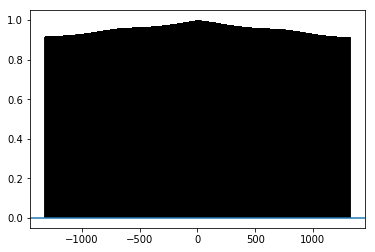

In [48]:
plt.xcorr(testing_result['temp'], testing_data_target['temp'], usevlines=1, maxlags=1319)

# Model Selection


In [71]:
data_frame2 = dataframe_input[['pressure','temp']]

x = np.empty((length, 2*history_steps))


def xrow (start):
    return data_frame2 [ start : start + history_steps ].values.flatten();


for n in  range(0,length):
    x[n] =xrow(n)
print(x.shape)
print(np.isnan(x).sum())

(31608, 20)
0


In [68]:
dataframe_input.columns

Index(['humidity', 'pressure', 'temp'], dtype='object')

## Scaling the features and splitting up into training and testing

In [72]:
cut = y_index.get_loc('2018-07-11 00:00:00')

In [73]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# x_train_sc = scaler.fit_transform(x_train)
# x_test_sc = scaler.fit_transform(x_test)
x_scaled = scaler.fit_transform(x)


#cut=len(y)*4//5 # First part of data is for training, the other testing

y_train = y[cut:]
x_train = x_scaled[cut:]
y_test = y[0:cut]
x_test = x_scaled[0:cut]

## Learning with linear regression

In [76]:
training_data_input  = x_train
training_data_target = y_train

testing_data_input   = x_test
testing_data_target  = y_test



from sklearn.linear_model import LinearRegression
regressor_temp = LinearRegression(n_jobs=-1)
regressor_temp = regressor_temp.fit(training_data_input, training_data_target['temp'])
sorted_coefs_temp = regressor_temp.coef_.reshape(history_steps,2)
intercept_temp = regressor_temp.intercept_

regressor_hum = LinearRegression(n_jobs=-1)
regressor_hum = regressor_hum.fit(training_data_input, training_data_target['humidity'])
sorted_coefs_hum = regressor_hum.coef_.reshape(history_steps,2)
intercept_hum = regressor_hum.intercept_

regressor_press = LinearRegression(n_jobs=-1)
regressor_press = regressor_press.fit(training_data_input, training_data_target['pressure'])
sorted_coefs_hum = regressor_press.coef_.reshape(history_steps,2)
intercept_hum = regressor_press.intercept_

training_result = pd.DataFrame(data={'temp' : regressor_temp.predict(training_data_input),'pressure' : regressor_press.predict(training_data_input), 'humidity' : regressor_hum.predict(training_data_input)}, index=y_train.index)
testing_result  = pd.DataFrame(data={'temp' : regressor_temp.predict(testing_data_input),'pressure' : regressor_press.predict(testing_data_input), 'humidity' : regressor_hum.predict(testing_data_input)}, index=y_test.index)

## Gathering Statistics

                            OLS Regression Results                            
Dep. Variable:                   temp   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     6996.
Date:                Sun, 05 Aug 2018   Prob (F-statistic):               0.00
Time:                        18:32:07   Log-Likelihood:                -34169.
No. Observations:               18488   AIC:                         6.838e+04
Df Residuals:                   18467   BIC:                         6.854e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.2316      0.013   2683.586      0.0

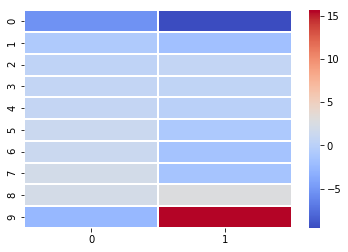

In [77]:
training_data_const = sm.add_constant(training_data_input)
linear_model = sm.OLS(training_data_target['temp'], training_data_const)
insample_stats = linear_model.fit()
testing_data_const = sm.add_constant(testing_data_input)
outsample_stats = insample_stats.predict(testing_data_const)

sn.heatmap(sorted_coefs_temp,cmap='coolwarm',linewidths=1)

print(insample_stats.summary())
#print(outsample_stats.summary())


In [85]:
for column in training_data_target.columns:
    err = np.sqrt(mean_squared_error(training_data_target[column],training_result[column]))
    print('Error in ' + column, err)

Error in humidity 4.834300314394833
Error in pressure 3.338168168641034
Error in temp 1.5457027027113674


In [86]:
for column in testing_data_target.columns:
    err = np.sqrt(mean_squared_error(testing_data_target[column],testing_result[column]))
    print('Error in ' + column, err)

Error in humidity 5.755824237474711
Error in pressure 3.9552659159749464
Error in temp 1.300672459652441


In [80]:
data_frame3 = dataframe_input[['temp']]

x = np.empty((length, history_steps))


def xrow (start):
    return data_frame3 [ start : start + history_steps ].values.flatten();


for n in  range(0,length):
    x[n] =xrow(n)
print(x.shape)
print(np.isnan(x).sum())

(31608, 10)
0


In [68]:
dataframe_input.columns

Index(['humidity', 'pressure', 'temp'], dtype='object')

## Scaling the features and splitting up into training and testing

In [81]:
cut = y_index.get_loc('2018-07-11 00:00:00')

In [82]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# x_train_sc = scaler.fit_transform(x_train)
# x_test_sc = scaler.fit_transform(x_test)
x_scaled = scaler.fit_transform(x)


#cut=len(y)*4//5 # First part of data is for training, the other testing

y_train = y[cut:]
x_train = x_scaled[cut:]
y_test = y[0:cut]
x_test = x_scaled[0:cut]

## Learning with linear regression

In [83]:
training_data_input  = x_train
training_data_target = y_train

testing_data_input   = x_test
testing_data_target  = y_test



from sklearn.linear_model import LinearRegression
regressor_temp = LinearRegression(n_jobs=-1)
regressor_temp = regressor_temp.fit(training_data_input, training_data_target['temp'])
sorted_coefs_temp = regressor_temp.coef_.reshape(history_steps,1)
intercept_temp = regressor_temp.intercept_

regressor_hum = LinearRegression(n_jobs=-1)
regressor_hum = regressor_hum.fit(training_data_input, training_data_target['humidity'])
sorted_coefs_hum = regressor_hum.coef_.reshape(history_steps,1)
intercept_hum = regressor_hum.intercept_

regressor_press = LinearRegression(n_jobs=-1)
regressor_press = regressor_press.fit(training_data_input, training_data_target['pressure'])
sorted_coefs_hum = regressor_press.coef_.reshape(history_steps,1)
intercept_hum = regressor_press.intercept_

training_result = pd.DataFrame(data={'temp' : regressor_temp.predict(training_data_input),'pressure' : regressor_press.predict(training_data_input), 'humidity' : regressor_hum.predict(training_data_input)}, index=y_train.index)
testing_result  = pd.DataFrame(data={'temp' : regressor_temp.predict(testing_data_input),'pressure' : regressor_press.predict(testing_data_input), 'humidity' : regressor_hum.predict(testing_data_input)}, index=y_test.index)

## Gathering Statistics

                            OLS Regression Results                            
Dep. Variable:                   temp   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                 1.380e+04
Date:                Sun, 05 Aug 2018   Prob (F-statistic):               0.00
Time:                        18:35:02   Log-Likelihood:                -34284.
No. Observations:               18488   AIC:                         6.859e+04
Df Residuals:                   18477   BIC:                         6.868e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.2171      0.013   2750.344      0.0

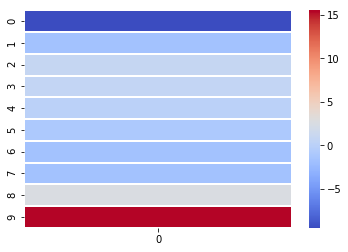

In [84]:
training_data_const = sm.add_constant(training_data_input)
linear_model = sm.OLS(training_data_target['temp'], training_data_const)
insample_stats = linear_model.fit()
testing_data_const = sm.add_constant(testing_data_input)
outsample_stats = insample_stats.predict(testing_data_const)

sn.heatmap(sorted_coefs_temp,cmap='coolwarm',linewidths=1)

print(insample_stats.summary())
#print(outsample_stats.summary())


In [87]:
for column in training_data_target.columns:
    err = np.sqrt(mean_squared_error(training_data_target[column],training_result[column]))
    print('Error in ' + column, err)

Error in humidity 4.834300314394833
Error in pressure 3.338168168641034
Error in temp 1.5457027027113674


In [88]:
for column in testing_data_target.columns:
    err = np.sqrt(mean_squared_error(testing_data_target[column],testing_result[column]))
    print('Error in ' + column, err)

Error in humidity 5.755824237474711
Error in pressure 3.9552659159749464
Error in temp 1.300672459652441
